In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/all_recipe_data.json"

In [3]:
import json
raw_recipe_data = pd.read_json(datafile)

## general data cleaning

In [4]:
raw_recipe_data.isnull().values.any()

False

In [5]:
raw_recipe_data = raw_recipe_data.replace(np.nan, "", regex=True)
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [6]:
raw_recipe_data.isnull().sum()

Author          0
Instructions    0
dtype: int64

In [7]:
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [8]:
raw_recipe_data.Author = raw_recipe_data.Author.apply(lambda x: x[0])

raw_recipe_data.Author.value_counts()

exception                    118
LoveMexiFood                  13
TheBritishBaker               13
witchywoman                   11
Johanna WISHES she were a     11
Litegal1                      10
Semigourmet                   10
Chef John                     10
Peach822                      10
ellie                         10
bellepepper                   10
Name: Author, dtype: int64

In [9]:
raw_recipe_data.drop(3, axis=0, inplace=True)
raw_recipe_data = raw_recipe_data[raw_recipe_data.Author != "exception"]


In [10]:
from string import punctuation

transtab = str.maketrans({key:None for key in punctuation if key != "."})

In [11]:
# remove punctuation
raw_recipe_data.Instructions = raw_recipe_data.Instructions.apply(lambda x: x.lower().translate(transtab).strip().split("."))
raw_recipe_data.head()

,Author,Instructions
0,witchywoman,[mix grapefruit orange apples pineapple marasc...
1,witchywoman,"[fill a margarita glass with crushed ice, pou..."
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...
4,witchywoman,[mix the teriyaki sauce garlic ginger and red ...
5,witchywoman,[fill a pint glass with ice and pour in the vo...


In [12]:
raw_recipe_data.Instructions.iloc[0]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl',
 ' mash slightly with the back of a wooden spoon to release juices',
 ' add bananas coconut walnuts and sugar stir to coat',
 ' cover and refrigerate to blend flavors at least 1 hour',
 '']

In [13]:
raw_recipe_data.loc[:,"FullInstruction"] = raw_recipe_data.Instructions.apply(lambda x: "".join(x))


In [14]:
# Get Instructions: List of list of sentences; DONE
# Flatten list of list of sentences -> List of sentences; DONE
# Remove stopwords from each sentence; DONE
# Create Train/Test split of sentences; DONE
# Pass Training set into Gensim; DONE

In [15]:
# get instructions
sentences = [text for text in raw_recipe_data.FullInstruction]
sentences[:3]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl mash slightly with the back of a wooden spoon to release juices add bananas coconut walnuts and sugar stir to coat cover and refrigerate to blend flavors at least 1 hour',
 'fill a margarita glass with crushed ice pour tequila melon liqueur and triple sec into the glass top with sour mix grenadine lime juice and orange juice garnish with the cherry and a wedge of orange',
 'preheat an oven to 350 degrees f 175 degrees c grease 12 muffin cups or line with paper muffin liners stir the flour cinnamon nutmeg allspice cloves pumpkin pie spice cardamom ginger salt and baking soda together in a bowl beat the brown sugar and the eggs together with an electric mixer in a large bowl until smooth add 12 cup plus 2 tablespoons vegetable oil and pumpkin continue beating until integrated pour the flour mixture into the egg mixture and beat until just incorporated fill the prepared muffin cups about halffull with 

In [20]:
# remove stop words
stoplist = set('a an and are as at be by for from has he in is it its of on or that the to was will with'.split(' '))
sentences_text = [[word for word in document.split() if word not in stoplist]
                  for document in sentences]

In [21]:
# flatten list of words of sentences
#combined_text = list(chain.from_iterable(sentences_text))
raw_recipe_data.dtypes

Author             object
Instructions       object
FullInstruction    object
dtype: object

In [22]:
raw_recipe_data['Author'] = raw_recipe_data['Author'].astype('category')
raw_recipe_data.dtypes

Author             category
Instructions         object
FullInstruction      object
dtype: object

In [23]:
raw_recipe_data['Author_codes'] = raw_recipe_data['Author'].cat.codes
raw_recipe_data.head()

,Author,Instructions,FullInstruction,Author_codes
0,witchywoman,[mix grapefruit orange apples pineapple marasc...,mix grapefruit orange apples pineapple marasch...,9
1,witchywoman,"[fill a margarita glass with crushed ice, pou...",fill a margarita glass with crushed ice pour t...,9
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...,preheat an oven to 350 degrees f 175 degrees c...,9
4,witchywoman,[mix the teriyaki sauce garlic ginger and red ...,mix the teriyaki sauce garlic ginger and red p...,9
5,witchywoman,[fill a pint glass with ice and pour in the vo...,fill a pint glass with ice and pour in the vod...,9


In [24]:
raw_recipe_data['Author_codes'].value_counts()

6    13
3    13
1    11
9    10
8    10
7    10
5    10
4    10
2    10
0    10
Name: Author_codes, dtype: int64

### Reserve 25% of corpus for testing

In [26]:
len(sentences_text)

107

In [25]:
np.random.shuffle(sentences_text)
train, test = sentences_text[:81], sentences_text[81:]

## Create our gensim model

In [27]:
# import modules & set up logging
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [28]:
model = gensim.models.Word2Vec(train, min_count=3, sg=1, window=5, sample=1e-3)

2018-05-03 16:20:41,605 : INFO : collecting all words and their counts
2018-05-03 16:20:41,608 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-03 16:20:41,612 : INFO : collected 1057 word types from a corpus of 4862 raw words and 81 sentences
2018-05-03 16:20:41,614 : INFO : Loading a fresh vocabulary
2018-05-03 16:20:41,619 : INFO : min_count=3 retains 406 unique words (38% of original 1057, drops 651)
2018-05-03 16:20:41,620 : INFO : min_count=3 leaves 4032 word corpus (82% of original 4862, drops 830)
2018-05-03 16:20:41,625 : INFO : deleting the raw counts dictionary of 1057 items
2018-05-03 16:20:41,627 : INFO : sample=0.001 downsamples 103 most-common words
2018-05-03 16:20:41,628 : INFO : downsampling leaves estimated 2964 word corpus (73.5% of prior 4032)
2018-05-03 16:20:41,631 : INFO : estimated required memory for 406 words and 100 dimensions: 527800 bytes
2018-05-03 16:20:41,632 : INFO : resetting layer weights
2018-05-03 16:20:41,643 : IN

In [29]:
X = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [30]:
word_vectors = model.wv

### Vectorize our instructions.. for Science!

In [33]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word not in index2word_set:
            if model.__contains__(word):
                nwords = nwords+1
                featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [145]:
raw_recipe_data['Instruction_Vectors'] = raw_recipe_data.FullInstruction.apply(lambda x: avg_sentence_vector(x.split(), word_vectors, num_features = 100, index2word_set = stoplist))


# Dimentionality Reduction

In [39]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)

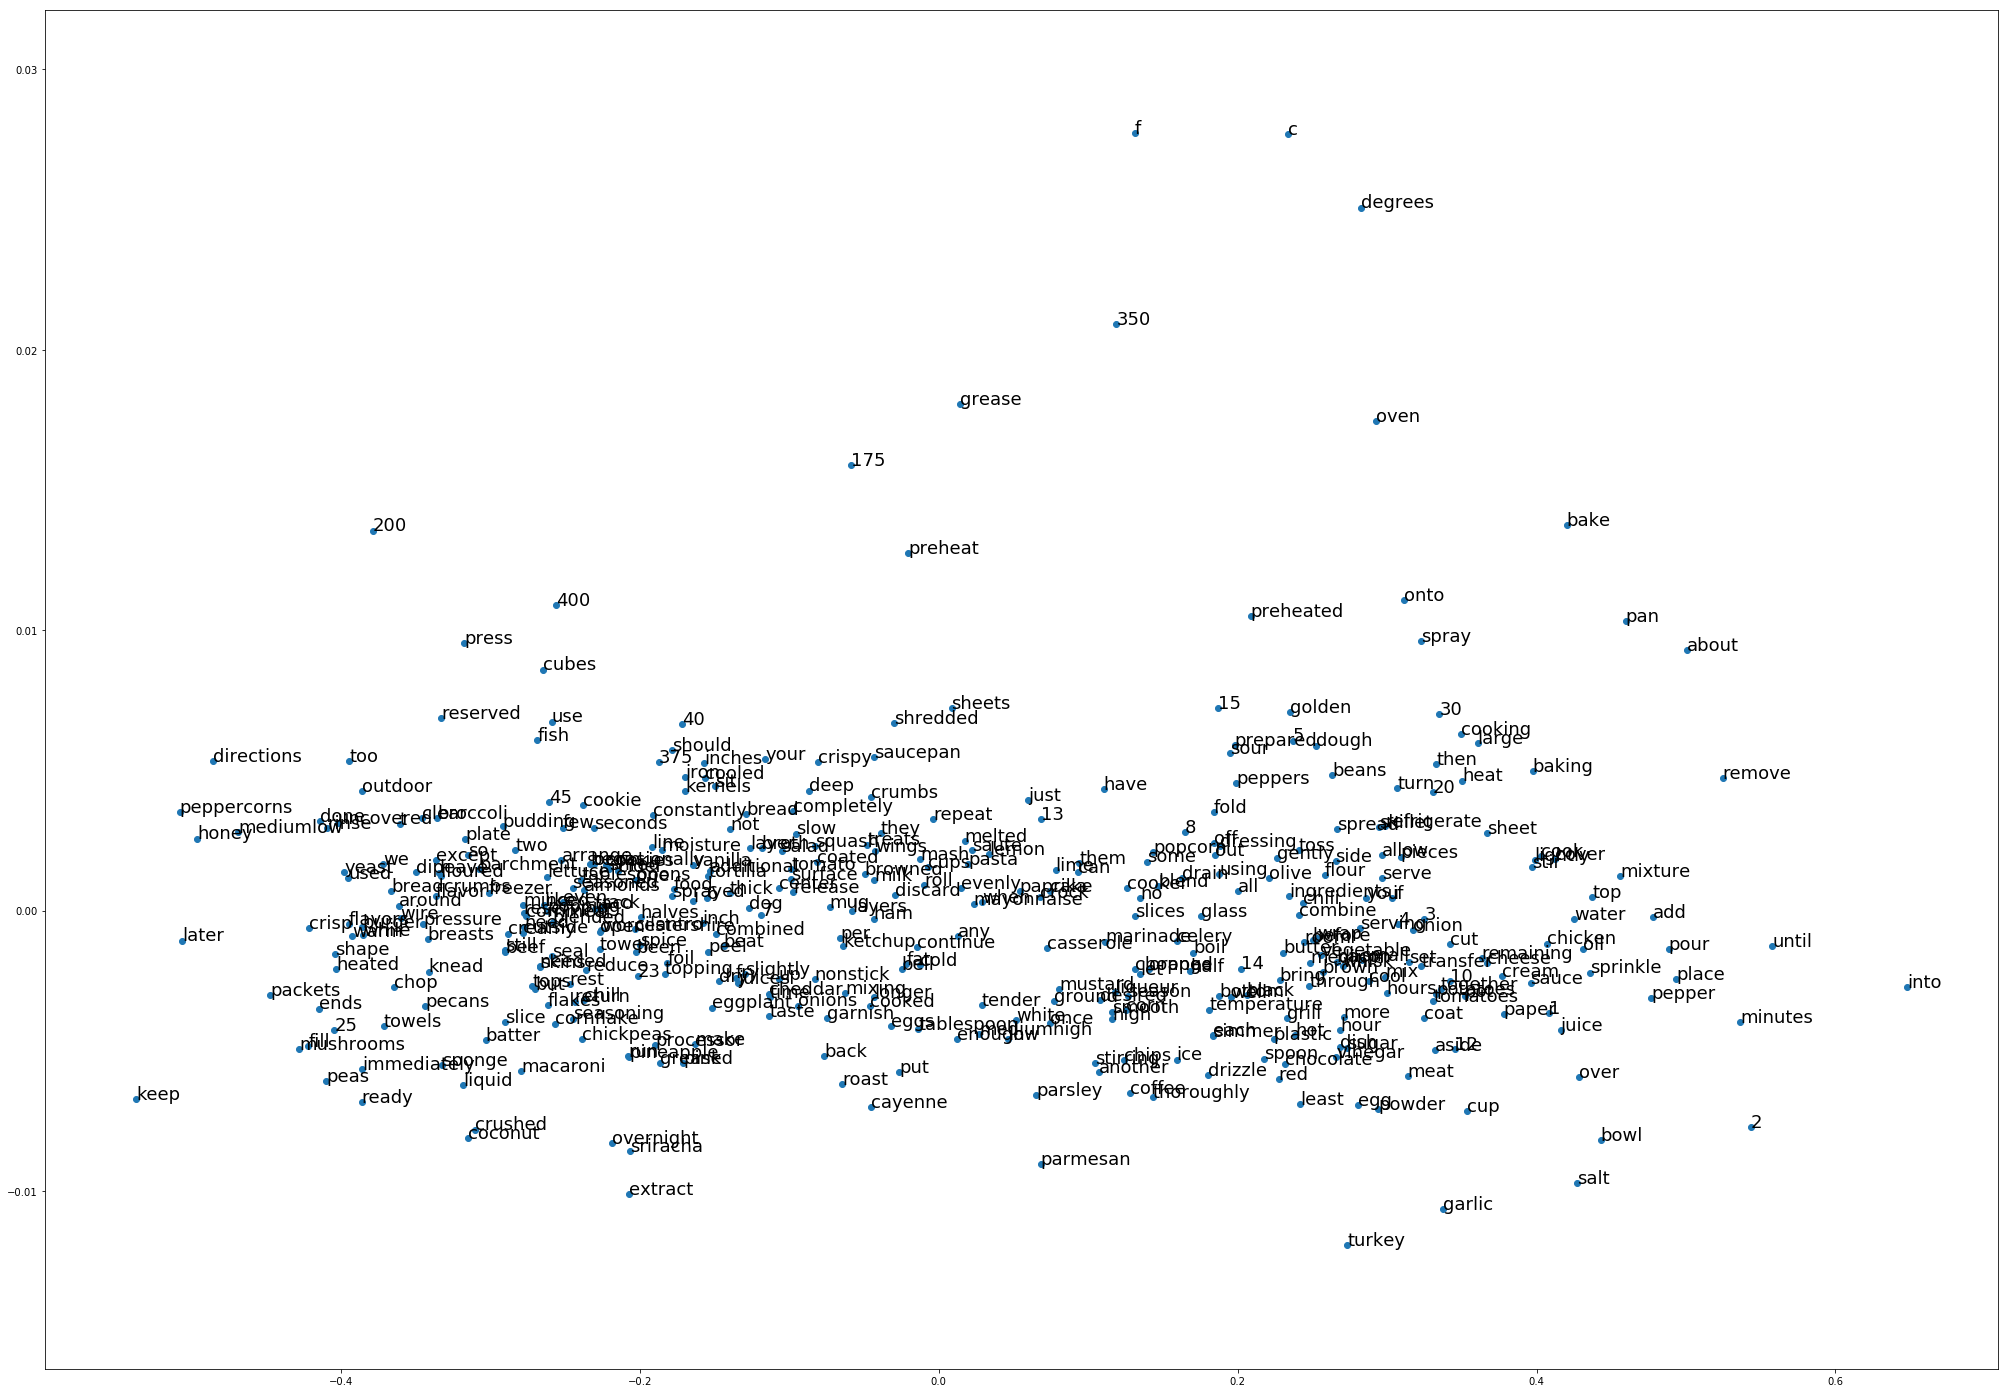

In [40]:
# PLOT PCA ONLY
plt.figure(figsize=((35,25)))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=18)


In [41]:
from sklearn import manifold

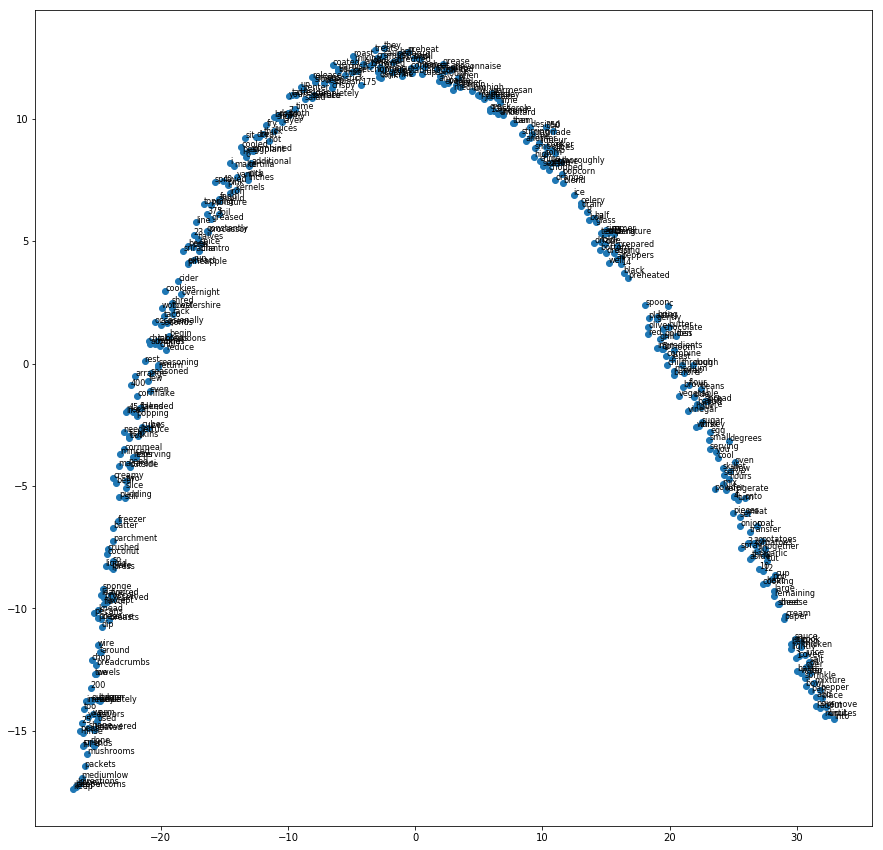

In [42]:
# PLOT TSNE ONLY
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data = tsne.fit_transform(X)
plt.figure(figsize=((15,15)))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(tsne_data[i, 0], tsne_data[i, 1]), fontsize=8)


/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


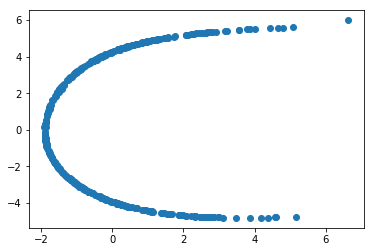

In [43]:
# PLOT MDS ONLY
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

mds = manifold.MDS(2, max_iter=200, n_init=1)
distances = dist.pairwise(X)
mds_data = mds.fit_transform(distances)
plt.scatter(mds_data[:, 0], mds_data[:, 1])

In [44]:
# PLOT TSVD ONLY
from sklearn.decomposition import TruncatedSVD
t_svd = TruncatedSVD(n_components=2)

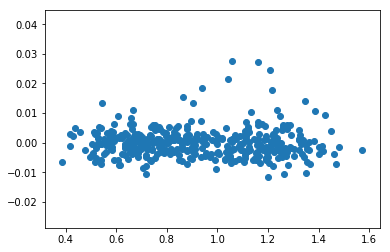

In [45]:
t_svd_data = t_svd.fit_transform(X)
plt.scatter(t_svd_data[:, 0], t_svd_data[:, 1])

# Clustering

In [46]:
# set up clustering estimators
from sklearn import cluster

dbscan = cluster.DBSCAN(metric='cityblock', algorithm='auto', min_samples=3, eps=.2) 
meanshift = cluster.MeanShift()
spectral = cluster.SpectralClustering()
affinity = cluster.AffinityPropagation(damping=.6, preference=.5)

# DBSCAN 

In [481]:
tsvd_dbscan = dbscan.fit(t_svd_data)
tsne_dbscan = dbscan.fit(tsne_data)
dbscan_pca = dbscan.fit(pca_data)
dbscan_mds = dbscan.fit(mds_data)

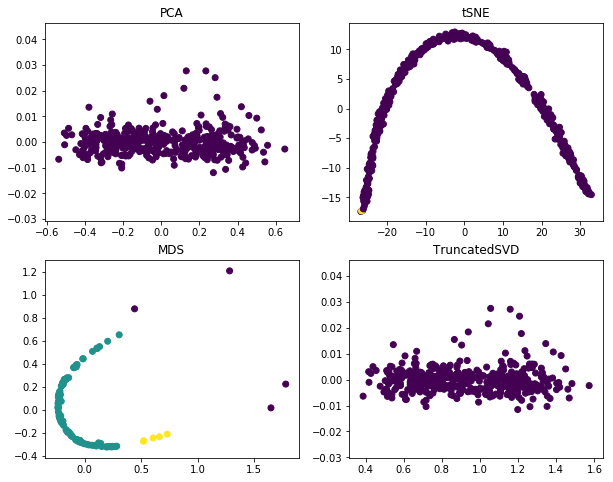

In [482]:
tsvd_dbscan_pred = dbscan.fit_predict(t_svd_data)
tsne_dbscan_pred = dbscan.fit_predict(tsne_data)
dbscan_pca_pred = dbscan.fit_predict(pca_data)
dbscan_mds_pred = dbscan.fit_predict(mds_data)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = dbscan_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_dbscan_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_dbscan_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = dbscan_mds_pred)
plt.title('MDS')

plt.show()

# MeanShift 

In [475]:
tsvd_meanshift = meanshift.fit(t_svd_data)
tsne_meanshift = meanshift.fit(tsne_data)
meanshift_pca = meanshift.fit(pca_data)
meanshift_mds = meanshift.fit(mds_data)

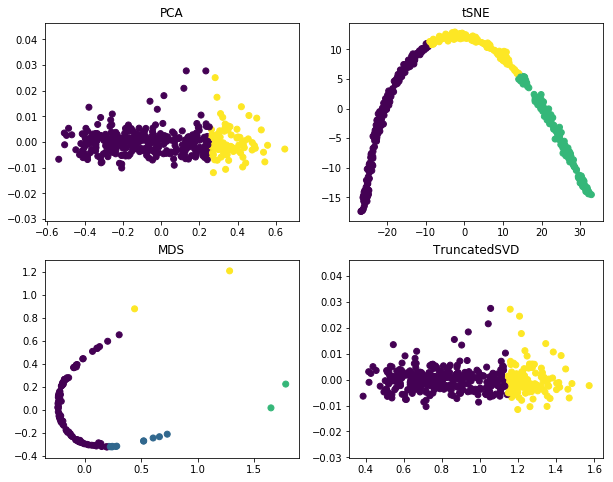

In [478]:
tsvd_meanshift_pred = meanshift.predict(t_svd_data)
tsne_meanshift_pred = meanshift.predict(tsne_data)
meanshift_pca_pred = meanshift.predict(pca_data)
meanshift_mds_pred = meanshift.predict(mds_data)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = meanshift_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_meanshift_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_meanshift_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = meanshift_mds_pred)
plt.title('MDS')

plt.show()

## Spectral Clustering 

In [469]:
tsvd_affinity = spectral.fit(t_svd_data)
tsne_affinity = spectral.fit(tsne_data)
affinity_pca = spectral.fit(pca_data)
affinity_mds = spectral.fit(mds_data)

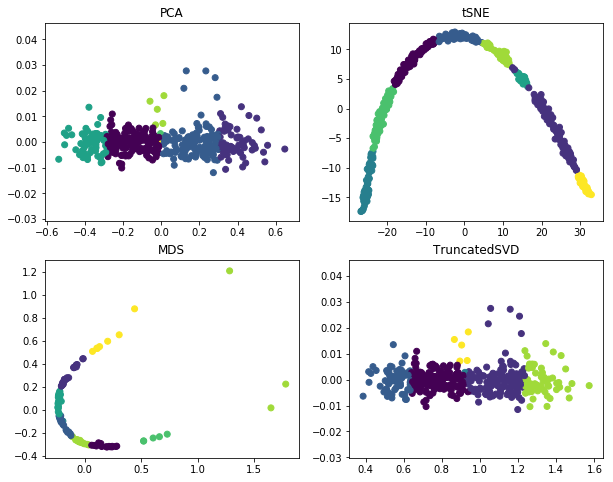

In [474]:
grid_size = (2,2)
tsvd_spectral_pred = spectral.fit_predict(t_svd_data)
tsne_spectral_pred = spectral.fit_predict(tsne_data)
spectral_pca_pred = spectral.fit_predict(pca_data)
spectral_mds_pred = spectral.fit_predict(mds_data)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = spectral_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_spectral_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_spectral_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = spectral_mds_pred)
plt.title('MDS')

plt.show()

## Affinity Propogation

In [466]:
tsvd_affinity = affinity.fit(t_svd_data)
tsne_affinity = affinity.fit(tsne_data)
affinity_pca = affinity.fit(pca_data)
affinity_mds = affinity.fit(mds_data)

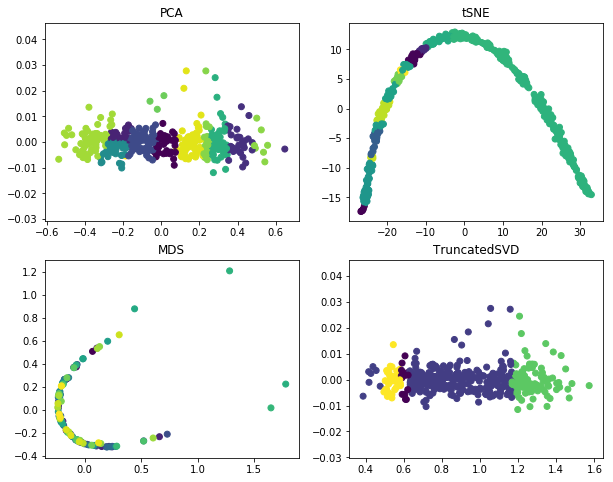

In [477]:
grid_size = (2,2)
tsvd_affinity_pred = affinity.predict(t_svd_data)
tsne_affinity_pred = affinity.predict(tsne_data)
affinity_pca_pred = affinity.predict(pca_data)
affinity_mds_pred = affinity.predict(mds_data)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = affinity_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_affinity_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_affinity_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = affinity_mds_pred)
plt.title('MDS')

plt.show()

# Supervised Learning

In [236]:
#assign X,y, split training and testing
y = raw_recipe_data['Author_codes']
X_vectors = raw_recipe_data['Instruction_Vectors'].values

X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=.25)

In [346]:
# reduce dimentionality
pca_X_vectors = pca.fit_transform(list(X_train))
tsne_X_vectors = tsne.fit_transform(list(X_train)) 
t_svd_X_vectors = t_svd.fit_transform(list(X_train))

X_vectors_distances = dist.pairwise(list(X_train))
mds_X_vectors = mds.fit_transform(X_vectors_distances)

pca_X_test = pca.fit_transform(list(X_test))
tsne_X_test = tsne.fit_transform(list(X_test)) 
t_svd_X_test = t_svd.fit_transform(list(X_test))

X_test_distances = dist.pairwise(list(X_test))
mds_X_test = mds.fit_transform(X_test_distances)


/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [332]:
# machine learning
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn import tree
from sklearn import linear_model


In [330]:
from sklearn.model_selection import GridSearchCV

def check_grid(estimator, params, X, y):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X, y)
    grid_score = grid_classifier.score(X, y)
    return (grid_classifier, grid_score)


In [188]:
# lets get some confusion matrices

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [340]:
log_param = {'tol': (.01, .5, 1, 5),
             'C': (.01, .5, 1, 5),
             'solver': ('newton-cg', 'lbfgs', 'sag')}
forest_type_param = {'n_estimators': (100, 200, 300),
                       'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_param = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 200, 300),
                   'max_depth':(2, 3, 4, 5, 6)}
svc_param = {'C': (.1, .5, 1, 5),
             'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
             'degree': (2, 3, 4, 5),
             'gamma': (1, 2, 3)}

# got my estimators
logr = linear_model.LogisticRegression()
gradient = ensemble.GradientBoostingClassifier()
svc = SVC()
forest = ensemble.RandomForestClassifier()

estimators = [logr,
              gradient,
              svc,
              forest]
params = [log_param,
          gradient_param,
          svc_param,
          forest_type_param]

In [358]:
results = []

for estimator, param in list(zip(estimators, params)):
        best_estimator, grid_score = check_grid(estimator, param, list(X_train), y_train)
        y_pred = best_estimator.predict(list(X_test))
        accuracy = metrics.accuracy_score(y_test, y_pred)
        results.append((best_estimator, accuracy))
    
print(results)


[(GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tol': (0.01, 0.5, 1, 5), 'C': (0.01, 0.5, 1, 5), 'solver': ('newton-cg', 'lbfgs', 'sag')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0), 0.07407407407407407), (GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fra

In [485]:
best_model = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)



In [489]:
best_model.fit(list(X_train), y_train)
print(best_model.score(list(X_train), y_train))
print(best_model.score(list(X_test), y_test))

1.0
0.25925925925925924


Confusion matrix, without normalization


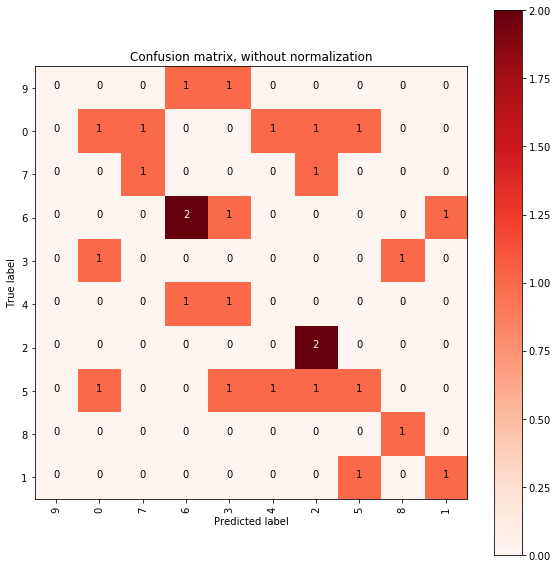

In [483]:
y_pred = best_model.predict(list(X_test))
c_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = y.unique()

plt.figure(figsize=(8, 8))
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

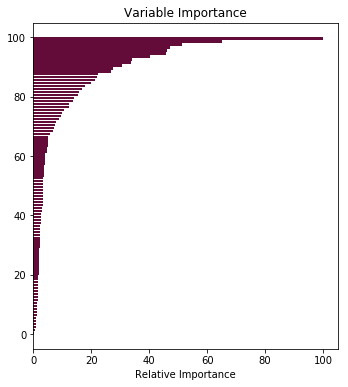

In [449]:
feature_importance = best_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
#plt.yticks(pos, best_model.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

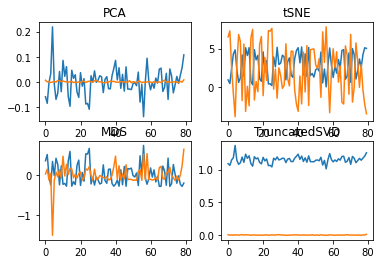

In [238]:
# subplots anyone
grid_size = (2,2)

plt.subplot2grid(grid_size, (0,0))
plt.plot(pca_X_vectors)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plt.plot(tsne_X_vectors)
plt.title('tSNE')
plt.subplot2grid(grid_size, (1,1))
plt.plot(t_svd_X_vectors)
plt.title('TruncatedSVD')
plt.subplot2grid(grid_size, (1,0))
plt.plot(mds_X_vectors)
plt.title('MDS')

plt.show()

In [306]:
# predict with PCA data
dbscan_pred_pca = dbscan.fit_predict(pca_X_vectors)
meanshift_pred_pca = meanshift.fit_predict(pca_X_vectors)
spectral_pred_pca = spectral.fit_predict(pca_X_vectors)
affinity_pred_pca = affinity.fit_predict(pca_X_vectors)

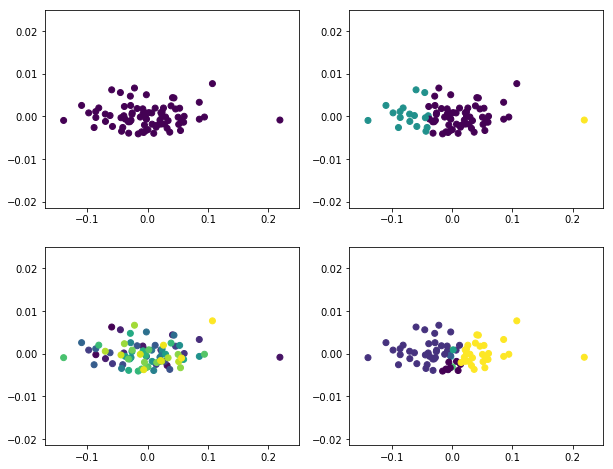

In [484]:
# Clustering with PCA data
grid_size = (2,2)

plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_X_vectors[:, 0], pca_X_vectors[:,1], c = dbscan_pred_pca)

plt.subplot2grid(grid_size, (0,1))
plt.scatter(pca_X_vectors[:, 0], pca_X_vectors[:,1], c = meanshift_pred_pca)

plt.subplot2grid(grid_size, (1,1))
plt.scatter(pca_X_vectors[:, 0], pca_X_vectors[:,1], c = spectral_pred_pca)

plt.subplot2grid(grid_size, (1,0))
plt.scatter(pca_X_vectors[:, 0], pca_X_vectors[:,1], c = affinity_pred_pca)

plt.show()

In [240]:
from sklearn.metrics import confusion_matrix
import itertools

In [242]:
classes = y.unique()
dbscan_confusion_matrix = confusion_matrix(dbscan_pred_pca, y_train)
meanshift_confusion_matrix = confusion_matrix(meanshift_pred_pca, y_train)
spectral_confusion_matrix = confusion_matrix(spectral_pred_pca, y_train)
affinity_confusion_matrix = confusion_matrix(affinity_pred_pca, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


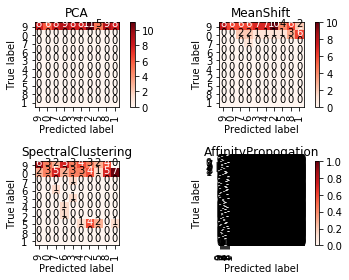

In [243]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_confusion_matrix, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_confusion_matrix, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_confusion_matrix, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_confusion_matrix, classes=classes)
plt.title('AffinityPropogation')

plt.show()

In [244]:
# predict with tSNE data
dbscan_pred_tsne = dbscan.fit_predict(tsne_X_vectors)
meanshift_pred_tsne = meanshift.fit_predict(tsne_X_vectors)
spectral_pred_tsne = spectral.fit_predict(tsne_X_vectors)
affinity_pred_tsne = affinity.fit_predict(tsne_X_vectors)

In [245]:
dbscan_cm_tsne = confusion_matrix(dbscan_pred_tsne, y_train)
meanshift_cm_tsne = confusion_matrix(meanshift_pred_tsne, y_train)
spectral_cm_tsne = confusion_matrix(spectral_pred_tsne, y_train)
affinity_cm_tsne = confusion_matrix(affinity_pred_tsne, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


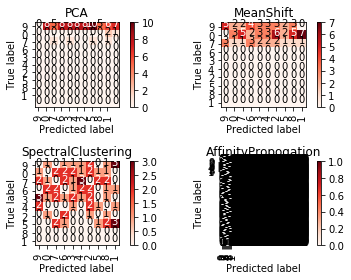

In [246]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_cm_tsne, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_cm_tsne, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_cm_tsne, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_cm_tsne, classes=classes)
plt.title('AffinityPropogation')

plt.show()

In [247]:
# predict with TruncatedSVD data
dbscan_pred_svd = dbscan.fit_predict(t_svd_X_vectors)
meanshift_pred_svd = meanshift.fit_predict(t_svd_X_vectors)
spectral_pred_svd = spectral.fit_predict(t_svd_X_vectors)
affinity_pred_svd = affinity.fit_predict(t_svd_X_vectors)

In [248]:
dbscan_cm_svd = confusion_matrix(dbscan_pred_svd, y_train)
meanshift_cm_svd = confusion_matrix(meanshift_pred_svd, y_train)
spectral_cm_svd = confusion_matrix(spectral_pred_svd, y_train)
affinity_cm_svd = confusion_matrix(affinity_pred_svd, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


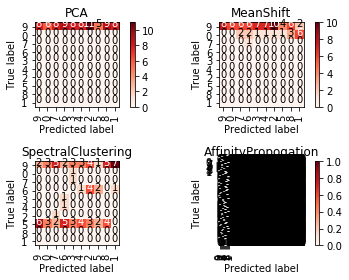

In [249]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_cm_svd, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_cm_svd, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_cm_svd, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_cm_svd, classes=classes)
plt.title('AffinityPropogation')

plt.show()

In [250]:
# predict with MDS data
dbscan_pred_mds = dbscan.fit_predict(mds_X_vectors)
meanshift_pred_mds = meanshift.fit_predict(mds_X_vectors)
spectral_pred_mds = spectral.fit_predict(mds_X_vectors)
affinity_pred_mds = affinity.fit_predict(mds_X_vectors)

In [251]:
dbscan_cm_mds = confusion_matrix(dbscan_pred_mds, y_train)
meanshift_cm_mds = confusion_matrix(meanshift_pred_mds, y_train)
spectral_cm_mds = confusion_matrix(spectral_pred_mds, y_train)
affinity_cm_mds = confusion_matrix(affinity_pred_mds, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


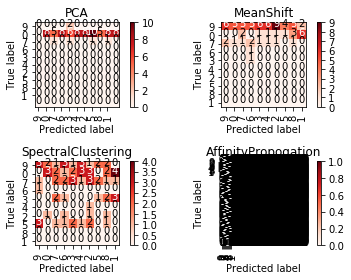

In [252]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_cm_mds, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_cm_mds, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_cm_mds, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_cm_mds, classes=classes)
plt.title('AffinityPropogation')

plt.show()